1. Compute the first (∆ct), second (CrossVart), third (CrossSkewt) and fourth (CrossKurt) central
cross-sectional moments of countries consumption growth. Provide the descriptive statistics of their
times series and plot their evolution

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import scipy.stats as st

data = pd.ExcelFile('Assignment_Exercise2_subsample_data.xlsx')

cons_growth = pd.read_excel(data, 'ConsGrowth')
msci_return = pd.read_excel(data, 'RI_LocalCur')
population = pd.read_excel(data, 'Population').set_index('Unnamed: 0')
cpi = pd.read_excel(data, 'CPI_Change').set_index('Unnamed: 0')
ff = pd.read_excel(data, 'FF').set_index('Unnamed: 0')


cons_growth = cons_growth.set_index('Name')
cpi = cpi.drop('Q3 1969')
population =  np.log(population).diff() * 400 # 400* diff(log(population))
population = population.drop('Q3 1969')

msci_return = msci_return.set_index('Name')
ff = ff.loc[196912::3].set_index(msci_return.index) # extract the quarters

In [38]:
ct = cons_growth - cpi - population

ct = ct.mean(axis=1)
crossvar = cons_growth.var(axis=1)
crossskew = cons_growth.skew(axis=1)
crosskur = cons_growth.kurt(axis=1)


#returns- take log difference to obtain return by country
returns = np.log(msci_return).diff()
returns = returns.iloc[1:,:]
returns['ct'] = ct
returns['RF'] = ff["RF"]
returns['Mkt_RF'] = ff["Mkt-RF"]
returns["CrossVar"] = crossvar
returns["CrossSkew"] = crossskew
returns["CrossKur"] = crosskur

# countries = cons_growth.columns.tolist() #list of countries involved in the analysis
countries = list(set(cpi.columns.values) & set(msci_return.columns.values)) #union set of countries that appear in both sets

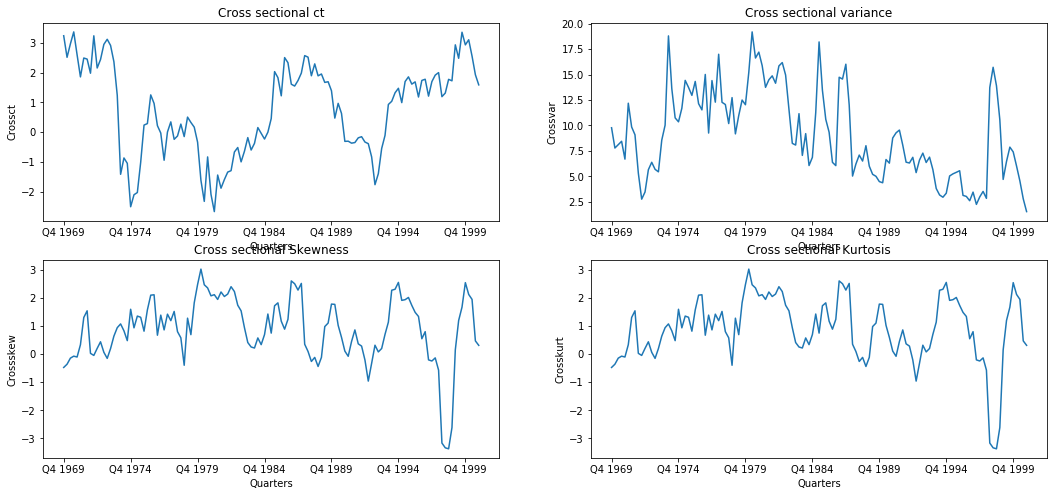

In [4]:
#print(crossvar.describe())
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(221)
ax1.plot(ct)
plt.title("Cross sectional ct")
plt.xlabel("Quarters")
plt.ylabel("Crossct")
ax1.xaxis.set_major_locator(tick.MultipleLocator(20))
ax2 = fig.add_subplot(222)
ax2.plot(crossvar)
plt.title("Cross sectional variance")
plt.xlabel("Quarters")
plt.ylabel("Crossvar")
ax2.xaxis.set_major_locator(tick.MultipleLocator(20))
ax3 = fig.add_subplot(223)
ax3.plot(crossskew)
plt.title("Cross sectional Skewness")
plt.xlabel("Quarters")
plt.ylabel("Crossskew")
ax3.xaxis.set_major_locator(tick.MultipleLocator(20))
ax4 = fig.add_subplot(224)
ax4.plot(crossskew)
plt.title("Cross sectional Kurtosis")
plt.xlabel("Quarters")
plt.ylabel("Crosskurt")
ax4.xaxis.set_major_locator(tick.MultipleLocator(20))


In [5]:
print(ct.describe())
print(ct.describe())
print(crossskew.describe())
print(crosskur.describe())

count    125.000000
mean       0.763159
std        1.520000
min       -2.671722
25%       -0.339452
50%        0.989873
75%        1.913906
max        3.366099
dtype: float64
count    125.000000
mean       0.763159
std        1.520000
min       -2.671722
25%       -0.339452
50%        0.989873
75%        1.913906
max        3.366099
dtype: float64
count    125.000000
mean       0.867710
std        1.157907
min       -3.370905
25%        0.197392
50%        0.858543
75%        1.736018
max        3.020728
dtype: float64
count    125.000000
mean       3.235676
std        3.284976
min       -1.211032
25%        0.551258
50%        2.338650
75%        5.280220
max       13.774407
dtype: float64


## CAPM Model

In [6]:
def capm_model(country_names, return_data):
    """
    capm modelweb
    """
    capm ={}  # capm model results
    capm_residuals ={}
    alpha_capm = []
    
    for country in country_names:
        capm_formula = country + "- RF ~ Mkt_RF"
        pf_data = return_data[[country,'RF', 'Mkt_RF']]
        excess_returns = pf_data[country].values - pf_data["RF"].values #excess returns for a given country
        realised_returns = excess_returns.mean()
        
        pf_data[country] = excess_returns 
        
        capm_res = sm.OLS.from_formula(capm_formula, data=pf_data).fit()
        beta_capm = capm_res.params["Mkt_RF"]
        alpha_capm = capm_res.params["Intercept"]
        beta_t_capm = capm_res.tvalues['Mkt_RF']
        alpha_t_capm = capm_res.tvalues['Intercept']
                
        capm_residuals[country] = capm_res.resid        
        capm[country] = [beta_capm, beta_t_capm, alpha_capm, alpha_t_capm, realised_returns]
        
        
    capm_df = pd.DataFrame.from_dict(capm, orient="index", columns=["Beta_CAPM","Mkt_RF t-value", "Alpha_CAPM", "Alpha t-value", "Realised_returns"])
    capm_resid = pd.DataFrame.from_dict(capm_residuals, orient="columns")
    return capm_df,capm_resid

In [7]:
capm_result, capm_residuals = capm_model(country_names = countries, return_data = returns)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [8]:
capm_result

,Beta_CAPM,Mkt_RF t-value,Alpha_CAPM,Alpha t-value,Realised_returns
Switzerland,0.022309,3.925123,-0.533266,-24.282418,-0.520109
Italy,0.021186,3.758330,-0.528992,-24.286932,-0.516497
Japan,0.021479,3.882441,-0.536593,-25.101867,-0.523926
Netherlands,0.021087,3.870136,-0.523455,-24.863863,-0.511019
UK,0.024040,4.349506,-0.524654,-24.567093,-0.510477
France,0.022526,4.000986,-0.525244,-24.145140,-0.511959
Spain,0.020234,3.614280,-0.524874,-24.264072,-0.512940
Belguim,0.021007,3.769290,-0.524154,-24.340804,-0.511765
Canada,0.025073,4.627552,-0.531460,-25.386271,-0.516673
Norway,0.019655,3.262225,-0.527288,-22.649710,-0.515697


In [9]:
capm_residuals

,Switzerland,Italy,Japan,Netherlands,UK,France,Spain,Belguim,Canada,Norway,Germany,Austria,Australia,Sweden
Name,,,,,,,,,,,,,,
Q1 1970,-0.055399,0.031163,0.027553,-0.055694,-0.054330,-0.019580,0.032126,-0.004198,0.067098,0.049243,-0.084516,-0.029604,-0.062726,-0.108537
Q2 1970,-0.036582,-0.076583,-0.054514,-0.020327,-0.027105,-0.033083,-0.030789,0.027506,-0.119969,0.046381,-0.112298,0.114232,0.005012,-0.054123
Q3 1970,-0.061885,-0.094535,-0.110971,0.029132,-0.020971,-0.082845,-0.105503,-0.038532,0.050584,0.099682,-0.034268,-0.002840,-0.065959,-0.114502
Q4 1970,-0.032710,-0.112012,-0.012007,-0.101361,-0.041677,0.004697,-0.005766,0.007118,0.021132,0.038172,-0.081907,0.012665,-0.135583,-0.051365
Q1 1971,0.285125,0.150083,0.327774,0.179725,0.196280,0.158307,0.188443,0.228659,0.200742,0.118502,0.337413,0.150482,0.162516,0.280892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q4 1999,0.018022,0.114766,0.035843,0.100175,0.017184,0.166856,0.140225,0.016468,0.126271,0.046655,0.237547,0.032711,0.018902,0.338516
Q1 2000,-0.074702,-0.006055,-0.034058,-0.045003,-0.117157,0.013409,0.009511,-0.255271,0.078763,-0.068678,0.053330,-0.091488,-0.035078,0.112690
Q2 2000,0.065045,0.071304,0.004416,0.071641,-0.002162,0.049871,-0.047680,0.100400,0.098117,0.109259,-0.086248,0.069202,0.123349,-0.036721


## CCAPM Model
$R_{i,t} − R_{f,t} = \alpha_i + \beta_i∆c_t + \epsilon_{it}$

In [14]:
len(countries)

14

In [16]:
def ccapm_model(country_names, return_data, consdata ):
    """
    ccapm model 
    """
    ccapm ={}  # capm model results
    ccapm_residuals ={}
    
    for country in country_names:
        ccapm_formula = country + "- RF ~ CT"
        pf_data = return_data[[country,'RF']]
        pf_data['CT'] = ct
        excess_returns = pf_data[country].values - pf_data["RF"].values #excess returns for a given country
        realised_returns = excess_returns.mean()
        
        pf_data[country] = excess_returns 
        
        ccapm_res = sm.OLS.from_formula(ccapm_formula, data=pf_data).fit()
        beta_ccapm = ccapm_res.params["CT"]
        alpha_ccapm = ccapm_res.params["Intercept"]
        beta_t_ccapm = ccapm_res.tvalues['CT']
        alpha_t_ccapm = ccapm_res.tvalues['Intercept']
        
                
        ccapm_residuals[country] = ccapm_res.resid        
        ccapm[country] = [beta_ccapm, beta_t_ccapm, alpha_ccapm, alpha_t_ccapm, realised_returns]
        
        
    ccapm_df = pd.DataFrame.from_dict(ccapm, orient="index", columns=["Beta_CCAPM", "CT t-value", "Alpha_CCAPM", "Alpha t-value", "Realised_returns"])
    ccapm_resid = pd.DataFrame.from_dict(ccapm_residuals, orient="columns")
    return ccapm_df,ccapm_resid

In [17]:
ccapm_results, ccapm_resid = ccapm_model(country_names=countries, return_data=returns, consdata=ct)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [18]:
ccapm_results

,Beta_CCAPM,CT t-value,Alpha_CCAPM,Alpha t-value,Realised_returns
Switzerland,0.063477,4.470079,-0.567286,-23.818379,-0.520109
Italy,0.059840,4.238278,-0.560971,-23.689259,-0.516497
Japan,0.066175,4.853127,-0.573107,-25.059957,-0.523926
Netherlands,0.058403,4.270324,-0.554424,-24.170470,-0.511019
UK,0.055266,3.883081,-0.551551,-23.105569,-0.510477
France,0.062918,4.462021,-0.558720,-23.624736,-0.511959
Spain,0.069084,5.083313,-0.564284,-24.756210,-0.512940
Belguim,0.066212,4.832342,-0.560974,-24.410579,-0.511765
Canada,0.068582,5.055455,-0.567644,-24.948187,-0.516673
Norway,0.079917,5.619754,-0.575091,-24.111829,-0.515697


In [19]:
ccapm_resid

,Switzerland,Italy,Japan,Netherlands,UK,France,Spain,Belguim,Canada,Norway,Germany,Austria,Australia,Sweden
Name,,,,,,,,,,,,,,
Q1 1970,-0.204500,-0.109651,-0.124951,-0.193801,-0.191761,-0.168048,-0.123470,-0.155988,-0.095594,-0.124563,-0.221005,-0.179707,-0.195761,-0.245662
Q2 1970,-0.319902,-0.344658,-0.338531,-0.284578,-0.303229,-0.316541,-0.313324,-0.253580,-0.432258,-0.256521,-0.370032,-0.150733,-0.248485,-0.314108
Q3 1970,-0.148284,-0.175426,-0.207424,-0.048344,-0.079618,-0.166999,-0.214055,-0.136779,-0.039282,-0.039364,-0.115629,-0.118203,-0.142058,-0.194770
Q4 1970,-0.035950,-0.114271,-0.024505,-0.101463,-0.020813,0.003604,-0.030044,-0.007873,0.022604,-0.009163,-0.087453,-0.022850,-0.137348,-0.055264
Q1 1971,0.293558,0.158583,0.330272,0.189471,0.219967,0.168128,0.183301,0.229443,0.213286,0.099270,0.343412,0.137451,0.170792,0.288035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q4 1999,0.038229,0.134921,0.044233,0.122769,0.067697,0.189830,0.133374,0.021407,0.155016,0.011976,0.252596,0.009933,0.038437,0.355871
Q1 2000,-0.121570,-0.049522,-0.091113,-0.085536,-0.136678,-0.031142,-0.060145,-0.314593,0.032595,-0.166556,0.007865,-0.170692,-0.075779,0.068674
Q2 2000,0.040629,0.048915,-0.028238,0.051451,-0.004721,0.027344,-0.090635,0.065766,0.075664,0.044370,-0.110755,0.017649,0.102505,-0.059945


## DLP Model

$R_{i,t} − R_{f,t} = \alpha_i + \beta_{1i}∆ct + \beta_{2i}CrossVar_t + \epsilon_{it} $

In [20]:
def dlp_model(country_names, return_data, consdata):
    """
    dlp model 
    """
    dlp ={}  # capm model results
    dlp_residuals ={}
    
    for country in country_names:
        dlp_formula = country + "- RF ~ CT + CrossVar"
        pf_data = return_data[[country,'RF', 'CrossVar']]
        pf_data['CT'] = ct
        excess_returns = pf_data[country].values - pf_data["RF"].values #excess returns for a given country
        realised_returns = excess_returns.mean()
        
        pf_data[country] = excess_returns 
        
        
        dlp_res = sm.OLS.from_formula(dlp_formula, data=pf_data).fit()
        beta_ct = dlp_res.params["CT"]
        beta_crossvar = dlp_res.params["CrossVar"]
        alpha_dlp = dlp_res.params["Intercept"]
        beta_t_ct = dlp_res.tvalues['CT']
        beta_t_crossvar = dlp_res.tvalues['CrossVar']
        alpha_t_dlp = dlp_res.tvalues['Intercept']
                
        dlp_residuals[country] = dlp_res.resid        
        dlp[country] = [beta_ct, beta_t_ct, beta_crossvar, beta_t_crossvar, alpha_dlp, alpha_t_dlp, realised_returns]
        
        
    dlp_df = pd.DataFrame.from_dict(dlp, orient="index", columns=["Beta_CT", "CT t-value", "Beta_CrossVar", "CrossVar t-value",
                                                                  "Alpha_DLP", "Alpha t-value", "Realised_returns"])
    dlp_resid = pd.DataFrame.from_dict(dlp_residuals, orient="columns")
    return dlp_df,dlp_resid

In [21]:
dlp_results, dlp_resid = dlp_model(country_names=countries, return_data=returns, consdata=ct)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [22]:
dlp_results

,Beta_CT,CT t-value,Beta_CrossVar,CrossVar t-value,Alpha_DLP,Alpha t-value,Realised_returns
Switzerland,0.039998,2.430144,-0.015095,-2.646482,-0.412607,-6.559487,-0.520109
Italy,0.039738,2.410306,-0.012924,-2.262073,-0.428539,-6.801424,-0.516497
Japan,0.051148,3.185482,-0.009661,-1.736279,-0.474110,-7.726304,-0.523926
Netherlands,0.034210,2.167204,-0.015553,-2.843358,-0.395043,-6.548427,-0.511019
UK,0.035240,2.119399,-0.012875,-2.234391,-0.419622,-6.603487,-0.510477
France,0.040438,2.469234,-0.014452,-2.546575,-0.410626,-6.560851,-0.511959
Spain,0.047178,2.990763,-0.014083,-2.576316,-0.419970,-6.966354,-0.512940
Belguim,0.045771,2.866730,-0.013141,-2.375080,-0.426314,-6.986560,-0.511765
Canada,0.049572,3.127296,-0.012222,-2.224906,-0.442407,-7.302907,-0.516673
Norway,0.055477,3.373649,-0.015712,-2.757289,-0.414083,-6.588968,-0.515697


In [23]:
dlp_resid

,Switzerland,Italy,Japan,Netherlands,UK,France,Spain,Belguim,Canada,Norway,Germany,Austria,Australia,Sweden
Name,,,,,,,,,,,,,,
Q1 1970,-0.182581,-0.090884,-0.110922,-0.171216,-0.173066,-0.147062,-0.103020,-0.136906,-0.077847,-0.101747,-0.201801,-0.158905,-0.179414,-0.229155
Q2 1970,-0.282426,-0.312572,-0.314546,-0.245963,-0.271265,-0.280660,-0.278360,-0.220954,-0.401915,-0.217512,-0.337199,-0.115167,-0.220536,-0.285885
Q3 1970,-0.096362,-0.130972,-0.174193,0.005156,-0.035333,-0.117288,-0.165612,-0.091577,0.002757,0.014682,-0.070138,-0.068927,-0.103335,-0.155667
Q4 1970,-0.028487,-0.107880,-0.019728,-0.093772,-0.014447,0.010750,-0.023081,-0.001375,0.028647,-0.001394,-0.080913,-0.015767,-0.131782,-0.049643
Q1 1971,0.366355,0.220910,0.376864,0.264481,0.282058,0.237826,0.251220,0.292819,0.272227,0.175046,0.407192,0.206539,0.225083,0.342859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q4 1999,0.064214,0.157169,0.060863,0.149544,0.089860,0.214709,0.157618,0.044029,0.176055,0.039024,0.275363,0.034594,0.057816,0.375440
Q1 2000,-0.112544,-0.041794,-0.085336,-0.076236,-0.128979,-0.022500,-0.051724,-0.306735,0.039903,-0.157161,0.015773,-0.162126,-0.069047,0.075471
Q2 2000,0.014566,0.026601,-0.044919,0.024596,-0.026950,0.002390,-0.114952,0.043075,0.054562,0.017241,-0.133590,-0.007086,0.083067,-0.079573


##  HO Model
$R_{i,t} − R_{f,t} = \alpha_i + \beta_{1i}∆c_t + \beta_{2i}CrossVar_t + \beta_{3i}CrossSkew_t + \beta_{4i}CrossKurt+  \epsilon_{it}$


In [53]:
def h0_model(country_names, return_data, consdata):
    """
    dlp model 
    """
    h0 ={}  # capm model results
    h0_residuals ={}
    
    for country in country_names:
        h0_formula = country + "- RF ~ CT + CrossVar + CrossSkew + CrossKur"
        pf_data = return_data[[country,'RF', 'CrossVar', 'CrossSkew', 'CrossKur']]
        pf_data['CT'] = ct
        excess_returns = pf_data[country].values - pf_data["RF"].values #excess returns for a given country
        realised_returns = excess_returns.mean()
        
        pf_data[country] = excess_returns 
        
        
        h0_res = sm.OLS.from_formula(h0_formula, data=pf_data).fit()
        beta_ct = h0_res.params["CT"]
        beta_crossvar = h0_res.params["CrossVar"]
        beta_crossskew = h0_res.params["CrossSkew"]
        beta_crosskur = h0_res.params["CrossKur"]
        beta_t_ct = h0_res.tvalues['CT']
        beta_t_crossskew = h0_res.tvalues['CrossVar']
        beta_t_crossvar = h0_res.tvalues['CrossSkew']
        beta_t_crosskur = h0_res.tvalues['CrossKur']
        
        
        alpha_h0 = h0_res.params["Intercept"]
        alpha_t_h0 = h0_res.tvalues['Intercept']
                
        h0_residuals[country] = h0_res.resid        
        h0[country] = [beta_ct, beta_t_ct, beta_crossvar, beta_t_crossvar, beta_crossskew, beta_t_crossskew,
                       beta_crosskur, beta_crosskur, alpha_h0, alpha_t_h0, realised_returns]
        
        
    h0_df = pd.DataFrame.from_dict(h0, orient="index", columns=["Beta_CT",
                                                                "CT t-value", "Beta_CrossVar", "CrossVar t-value",
                                                                "Beta_CrossSkew", "CrossSkew t-value", "Beta_CrossKur",
                                                                "CrossKur t-value", "Alpha_H0", "Alpha t-value", "Realised_returns"])
    h0_resid = pd.DataFrame.from_dict(h0_residuals, orient="columns")
    return h0_df,h0_resid

In [54]:
h0_results, h0_resid = h0_model(country_names=countries, return_data=returns, consdata=ct)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [55]:
h0_results

,Beta_CT,CT t-value,Beta_CrossVar,CrossVar t-value,Beta_CrossSkew,CrossSkew t-value,Beta_CrossKur,CrossKur t-value,Alpha_H0,Alpha t-value,Realised_returns
Switzerland,0.034060,2.044351,-0.014015,-2.486594,-0.046985,-2.113160,0.001153,0.001153,-0.380480,-5.917978,-0.520109
Italy,0.033483,2.004819,-0.012291,-2.467620,-0.046741,-1.848758,0.002081,0.002081,-0.395342,-6.134174,-0.516497
Japan,0.048653,2.966538,-0.006697,-1.796882,-0.033423,-1.025704,-0.003823,-0.003823,-0.457410,-7.227444,-0.523926
Netherlands,0.028730,1.789534,-0.014963,-2.259941,-0.041149,-2.341231,0.001760,0.001760,-0.365913,-5.906298,-0.511019
UK,0.029270,1.725357,-0.013041,-2.100821,-0.040420,-1.931032,0.003308,0.003308,-0.388916,-5.940810,-0.510477
France,0.034448,2.078639,-0.013425,-2.504146,-0.047066,-2.034933,0.001269,0.001269,-0.378293,-5.915391,-0.511959
Spain,0.042185,2.641418,-0.012344,-2.431408,-0.044039,-1.941607,-0.000457,-0.000457,-0.391895,-6.358972,-0.512940
Belguim,0.038493,2.411133,-0.012249,-3.051090,-0.055243,-1.927448,0.002154,0.002154,-0.387483,-6.289684,-0.511765
Canada,0.046027,2.828326,-0.011131,-1.651509,-0.030481,-1.718298,-0.000076,-0.000076,-0.422657,-6.730417,-0.516673
Norway,0.055253,3.261475,-0.012356,-1.032654,-0.019841,-1.832206,-0.005645,-0.005645,-0.408641,-6.250865,-0.515697


In [27]:
h0_resid

,Switzerland,Italy,Japan,Netherlands,UK,France,Spain,Belguim,Canada,Norway,Germany,Austria,Australia,Sweden
Name,,,,,,,,,,,,,,
Q1 1970,-0.225070,-0.129961,-0.157014,-0.205864,-0.201707,-0.189234,-0.148100,-0.184136,-0.108226,-0.140642,-0.232490,-0.203250,-0.199980,-0.248098
Q2 1970,-0.312385,-0.338837,-0.353453,-0.269358,-0.288266,-0.310239,-0.312269,-0.253155,-0.424473,-0.253399,-0.355718,-0.150047,-0.230658,-0.296526
Q3 1970,-0.121532,-0.152645,-0.208834,-0.014184,-0.048642,-0.142090,-0.194747,-0.118295,-0.016542,-0.018046,-0.084747,-0.099333,-0.110504,-0.163779
Q4 1970,-0.056900,-0.133119,-0.054989,-0.116225,-0.031387,-0.017342,-0.054697,-0.032196,0.007544,-0.033265,-0.099276,-0.047924,-0.142501,-0.060429
Q1 1971,0.345299,0.202840,0.347582,0.248351,0.271075,0.217085,0.226747,0.270520,0.256029,0.147266,0.395118,0.180932,0.219293,0.336201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q4 1999,0.149888,0.236617,0.150543,0.219934,0.149237,0.299824,0.247437,0.139821,0.236733,0.113147,0.338829,0.122172,0.101514,0.415018
Q1 2000,-0.041035,0.025466,-0.015192,-0.016723,-0.077072,0.048659,0.021686,-0.225971,0.089714,-0.101509,0.071038,-0.091681,-0.029356,0.110501
Q2 2000,0.077826,0.086207,0.016611,0.077327,0.019229,0.065352,-0.050184,0.114612,0.098534,0.065782,-0.084446,0.054937,0.118537,-0.048363


## Estimate and test each model
# Wald Statistics

#### CAPM model Wald test

In [29]:
T = capm_residuals.shape[0]
N = capm_residuals.shape[1]
con_names = capm_residuals.columns
mu_CAPM = ff['Mkt-RF'].mean()
Mkt_RF = np.array(ff['Mkt-RF'])
sigma2_CAPM = 1/T * np.dot(Mkt_RF.T, Mkt_RF)
el_CAPM = []
for x in con_names:
    el_CAPM.append(list(capm_residuals[x]))
resid_sigma_CAPM = pd.DataFrame(np.dot(el_CAPM, np.transpose(el_CAPM))/T, index=con_names, columns=con_names)

In [30]:
alpha_capm = capm_result['Alpha_CAPM'].values
alpha_hat_CAPM = (1 + (mu_CAPM**2/sigma2_CAPM))**(-1)

Var_alpha_hat_CAPM = np.dot(np.transpose(alpha_capm),
                            np.dot(np.dot(np.linalg.inv(np.dot(resid_sigma_CAPM.T,resid_sigma_CAPM)),resid_sigma_CAPM.T),alpha_capm))
J0_CAPM = T * alpha_hat_CAPM * Var_alpha_hat_CAPM
P_J0_CAPM = st.chi2.sf(J0_CAPM, N)
print('J0 Statistic CAPM:', J0_CAPM)
print('P Value CAPM:', P_J0_CAPM)
print("------------------------------------------")

J1_CAPM = ((T-N-1)/N) * alpha_hat_CAPM * Var_alpha_hat_CAPM
P_J1_CAPM = st.f.sf(J1_CAPM, N, (T-N-1))
print('J1 Statistic CAPM:', J1_CAPM)
print('P Value CAPM:', P_J1_CAPM)

J0 Statistic CAPM: 739.1117905836411
P Value CAPM: 1.1474970293621116e-148
------------------------------------------
J1 Statistic CAPM: 46.40736473134612
P Value CAPM: 2.521817309396053e-39


#### CCAPM model Wald Test

In [31]:
T = ccapm_resid.shape[0]
N = ccapm_resid.shape[1]
con_names = ccapm_resid.columns
mu_CCAPM = returns['CrossVar'].mean()
CrossVar = np.array(returns['CrossVar'])
sigma2_CCAPM = 1/T * np.dot(CrossVar.T, CrossVar)
el_CCAPM = []
for x in con_names:
    el_CCAPM.append(list(ccapm_resid[x]))
resid_sigma_CCAPM = pd.DataFrame(np.dot(el_CCAPM, np.transpose(el_CCAPM))/T, index=con_names, columns=con_names)

In [33]:
alpha_ccapm = ccapm_results['Alpha_CCAPM'].values
alpha_hat_CCAPM = (1 + (mu_CCAPM**2/sigma2_CCAPM))**(-1)

Var_alpha_hat_CCAPM = np.dot(np.transpose(alpha_ccapm),
                            np.dot(np.dot(np.linalg.inv(np.dot(resid_sigma_CCAPM.T,resid_sigma_CCAPM)),resid_sigma_CCAPM.T),alpha_ccapm))
J0_CCAPM = T * alpha_hat_CCAPM * Var_alpha_hat_CCAPM
P_J0_CCAPM = st.chi2.sf(J0_CCAPM, N)
print('J0 Statistic CCAPM:', J0_CCAPM)
print('P Value CCAPM:', P_J0_CCAPM)
print("------------------------------------------")

J1_CCAPM = ((T-N-1)/N) * alpha_hat_CCAPM * Var_alpha_hat_CCAPM
P_J1_CCAPM = st.f.sf(J1_CCAPM, N, (T-N-1))
print('J1 Statistic CCAPM:', J1_CCAPM)
print('P Value CCAPM:', P_J1_CCAPM)

J0 Statistic CCAPM: 558.7105947580063
P Value CCAPM: 3.2102557498131344e-110
------------------------------------------
J1 Statistic CCAPM: 35.080331122478505
P Value CCAPM: 6.853170204971903e-34


#### DLP model Wald Test

In [39]:
T = dlp_resid.shape[0]
N = dlp_resid.shape[1]
con_names = dlp_resid.columns
mu_dlp = returns[['CrossVar','ct']].mean()
dlp = np.array(returns[['CrossVar','ct']])
sigma2_dlp = 1/T * np.dot(dlp.T, dlp)
el_dlp = []
for x in con_names:
    el_dlp.append(list(dlp_resid[x]))
resid_sigma_dlp = pd.DataFrame(np.dot(el_dlp, np.transpose(el_dlp))/T, index=con_names, columns=con_names)

In [59]:
alpha_dlp = dlp_results['Alpha_DLP'].values
alpha_hat_dlp = (1 + np.dot(mu_dlp.T,np.dot(np.dot(np.linalg.inv(np.dot(sigma2_dlp.T, sigma2_dlp)),sigma2_dlp.T),mu_dlp)))**(-1)

Var_alpha_hat_dlp = np.dot(np.transpose(alpha_dlp),
                            np.dot(np.dot(np.linalg.inv(np.dot(resid_sigma_dlp.T,resid_sigma_dlp)),resid_sigma_dlp.T),alpha_dlp))
J0_DLP = T * alpha_hat_dlp * Var_alpha_hat_dlp
P_J0_DLP = st.chi2.sf(J0_DLP, N)
print('J0 Statistic DLP:', J0_DLP)
print('P Value DLP:', P_J0_DLP)
print("------------------------------------------")

J1_DLP = ((T-N-1)/N) * alpha_hat_dlp * Var_alpha_hat_dlp
P_J1_DLP = st.f.sf(J1_DLP, N, (T-N-1))
print('J1 Statistic DLP:', J1_DLP)
print('P Value DLP:', P_J1_DLP)

J0 Statistic DLP: 420.8030378868023
P Value DLP: 5.214889054314098e-81
------------------------------------------
J1 Statistic DLP: 26.421388899574566
P Value DLP: 1.070397794156357e-28


#### H0 model Wald Test

In [60]:
T = h0_resid.shape[0]
N = h0_resid.shape[1]
con_names = h0_resid.columns
mu_h0 = returns[['CrossVar','ct','CrossSkew', 'CrossKur']].mean()
h0 = np.array(returns[['CrossVar','ct','CrossSkew', 'CrossKur']])
sigma2_h0 = 1/T * np.dot(h0.T, h0)
el_h0 = []
for x in con_names:
    el_h0.append(list(h0_resid[x]))
resid_sigma_h0 = pd.DataFrame(np.dot(el_h0, np.transpose(el_h0))/T, index=con_names, columns=con_names)

In [61]:
alpha_h0 = h0_results['Alpha_H0'].values
alpha_hat_h0 = (1 + np.dot(mu_h0.T,np.dot(np.dot(np.linalg.inv(np.dot(sigma2_h0.T, sigma2_h0)),sigma2_h0.T),mu_h0)))**(-1)

Var_alpha_hat_h0 = np.dot(np.transpose(alpha_h0),
                            np.dot(np.dot(np.linalg.inv(np.dot(resid_sigma_h0.T,resid_sigma_h0)),resid_sigma_h0.T),alpha_h0))
J0_H0 = T * alpha_hat_h0 * Var_alpha_hat_h0
P_J0_H0 = st.chi2.sf(J0_DLP, N)
print('J0 Statistic H0:', J0_H0)
print('P Value H0:', P_J0_H0)
print("------------------------------------------")

J1_H0 = ((T-N-1)/N) * alpha_hat_h0 * Var_alpha_hat_h0
P_J1_H0 = st.f.sf(J1_DLP, N, (T-N-1))
print('J1 Statistic H0:', J1_H0)
print('P Value H0:', P_J1_H0)

J0 Statistic H0: 424.8795388257998
P Value H0: 5.214889054314098e-81
------------------------------------------
J1 Statistic H0: 26.677344315675214
P Value H0: 1.070397794156357e-28
